In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize
import sys
from collections import Counter
from sklearn.linear_model import LinearRegression
sys.path.append('../../')
from mmctools.helper_functions import calc_uv
from mmctools.helper_functions import calc_wind
from mmctools.wrf.utils import Tower, tsout_seriesReader
from pydicts.obsdict import read_AWOS, AWOS_to_ds
from pydicts.baybreezedict import DetectBayBreeze
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import os

# Where to save the images:

In [78]:
save_dir  = '/Users/hawbecke/Research/Chesapeake/Papers/SST_Paper/img/'
save_figs = True

# Read in ASOS data:

In [4]:
asos_path = '/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/ASOS_2019to2020.nc'
#asos_path = '/Users/hawbecke/Research/Chesapeake/Data/Obs/ASOS/5min/ASOS_2007to2019.nc'

if path.exists(asos_path):
    print('loading in full dataset!')
    asos_ds = xr.open_dataset(asos_path)
else:
    print('Please run AWOS_Station_Locations notebook to get data')


loading in full dataset!


# Read in AWOS data:

In [5]:
awos_path = '/Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/AWOS_2019to2020.nc'
#awos_path = '/Users/hawbecke/Research/Chesapeake/Data/Obs/AWOS/2007_to_2020/AWOS_2007to2020.nc'

if path.exists(awos_path):
    print('loading in full dataset!')
    awos_ds = xr.open_dataset(awos_path)
else:
    print('Please run AWOS_Station_Locations notebook to get data')


loading in full dataset!


# Read in APG data:

In [6]:
apg_path = '/Users/hawbecke/Research/Chesapeake/Data/Obs/APG/APG_data_2019.nc'
if path.exists(apg_path):
    print('loading in full dataset!')
    apg_ds = xr.open_dataset(apg_path)
else:
    print('Please run AWOS_Station_Locations notebook to get data')
apg_stn_list = list(apg_ds.station.data)
for ss,apg_stn in enumerate(apg_stn_list):
    if apg_stn == 'PAA':
        apg_stn_list[ss] = 'APG'
apg_ds = apg_ds.assign_coords({'station': apg_stn_list})
non_apg_list = apg_stn_list.copy()
non_apg_list.remove('APG')
apg_ds = apg_ds.drop_sel(station=non_apg_list)
apg_ds = apg_ds.drop(['rh','gust','radt','rain','alt'])

loading in full dataset!


# Combine AWOS and APG:

In [7]:
temp = awos_ds.sel(station='APG').combine_first(apg_ds)
temp = temp.squeeze()
temp = temp.expand_dims('station')

lat_da = xr.DataArray([float(apg_ds.lat)], dims=('station'))
lon_da = xr.DataArray([float(apg_ds.lon)], dims=('station'))

temp = temp.assign_coords({'lat':lat_da})
temp = temp.assign_coords({'lon':lon_da})

awos_ds = awos_ds.drop_sel(station=['APG'])

awos_ds = xr.merge([awos_ds,temp])

# Plot combined AWOS and ASOS near-shore stations and IAD

In [8]:
awos_near_shore_stations  = []
asos_near_shore_stations  = []
for stn in awos_ds.get_index('station'):
    if awos_ds.sel(station=stn).region.data == 'coastal':
        awos_near_shore_stations.append(stn)
                                         
for stn in asos_ds.get_index('station'):
    if asos_ds.sel(station=stn).region.data == 'coastal':
        asos_near_shore_stations.append(stn)


both_near_shore_stations = []
for stn in awos_near_shore_stations:
    if stn in asos_near_shore_stations:
        both_near_shore_stations.append(stn)

for stn in both_near_shore_stations:
    if stn in awos_near_shore_stations:
        awos_near_shore_stations.remove(stn)
    if stn in asos_near_shore_stations:
        asos_near_shore_stations.remove(stn)

station_dict = {}
for stn in awos_near_shore_stations:
    station_dict[stn] = {'lat':float(awos_ds.sel(station=stn).lat.data),
                         'lon':float(awos_ds.sel(station=stn).lon.data),
                         'min':float(awos_ds.sel(station=stn).onshore_min.data),
                         'max':float(awos_ds.sel(station=stn).onshore_max.data),
                           #'c':'#e3e022'}
                           'c':'goldenrod'}
for stn in asos_near_shore_stations:
    station_dict[stn] = {'lat':float(asos_ds.sel(station=stn).lat.data),
                         'lon':float(asos_ds.sel(station=stn).lon.data),
                         'min':float(asos_ds.sel(station=stn).onshore_min.data),
                         'max':float(asos_ds.sel(station=stn).onshore_max.data),
                           'c':'b'}
for stn in both_near_shore_stations:
    station_dict[stn] = {'lat':float(awos_ds.sel(station=stn).lat.data),
                         'lon':float(awos_ds.sel(station=stn).lon.data),
                         'min':float(awos_ds.sel(station=stn).onshore_min.data),
                         'max':float(awos_ds.sel(station=stn).onshore_max.data),
                           'c':'coral'}


# Load in WRF-calculated min/max:

In [9]:
onshore_min_max_path = '/Users/hawbecke/Research/Chesapeake/Data/WRF/20190716to20190801/onshore_min_max.nc'
if path.exists(onshore_min_max_path):
    print('loading in onshore min/max dataset!')
    wrf_onshore_min_max_ds = xr.open_dataset(onshore_min_max_path)
    wrf_onshore_min = wrf_onshore_min_max_ds.onshore_min
    wrf_onshore_max = wrf_onshore_min_max_ds.onshore_max
else:
    print('Run BayBreezeDetectionModel.ipynb')

loading in onshore min/max dataset!


In [10]:
use_wrf_minmax = True

lon = wrf_onshore_min_max_ds.XLONG
lat = wrf_onshore_min_max_ds.XLAT
for ss,stn in enumerate(station_dict):
    #if stn == 'APG':
    #    stn_ds = apg_ds.sel(station=stn)
    if stn in awos_ds.station:
        stn_ds = awos_ds.sel(station=stn)
    elif stn in asos_ds.station:
        stn_ds = asos_ds.sel(station=stn)
    stn_lat = stn_ds.lat.data
    stn_lon = stn_ds.lon.data
    dist_from_stn = ((lon-stn_lon)**2 + (lat-stn_lat)**2)**0.5
    stn_j,stn_i = np.where(dist_from_stn == np.nanmin(dist_from_stn))
    stn_j = int(stn_j)
    stn_i = int(stn_i)
    if stn == 'NHK': print('{},{}'.format(stn_i,stn_j))
    print('Station: {}'.format(stn))
    print('\tOnshore min - Old: {0:4.3f}\tNew: {1:4.3f}'.format(stn_ds.onshore_min.data,wrf_onshore_min.data[stn_j,stn_i]))
    print('\tOnshore max - Old: {0:4.3f}\tNew: {1:4.3f}'.format(stn_ds.onshore_max.data,wrf_onshore_max.data[stn_j,stn_i]))
    if use_wrf_minmax:
        station_dict[stn]['min'] = wrf_onshore_min.data[stn_j,stn_i]
        station_dict[stn]['max'] = wrf_onshore_max.data[stn_j,stn_i]


Station: APG
	Onshore min - Old: 50.000	New: 104.086
	Onshore max - Old: 200.000	New: 200.313
Station: MTN
	Onshore min - Old: 70.000	New: 80.538
	Onshore max - Old: 190.000	New: 182.490
Station: BWI
	Onshore min - Old: 60.000	New: 62.050
	Onshore max - Old: 160.000	New: 162.680
Station: NAK
	Onshore min - Old: 20.000	New: 29.745
	Onshore max - Old: 190.000	New: 194.036
104,85
Station: NHK
	Onshore min - Old: 0.000	New: -0.000
	Onshore max - Old: 170.000	New: 194.800
Station: NUI
	Onshore min - Old: 0.000	New: 1.700
	Onshore max - Old: 150.000	New: 215.916


In [11]:
buoy_ds = xr.open_dataset('/Users/hawbecke/Research/Chesapeake/Data/Obs/Buoy/combined_buoy_data_res_2019.nc')

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


/Users/hawbecke/Research/Chesapeake/Papers/SST_Paper/img/StationLocation


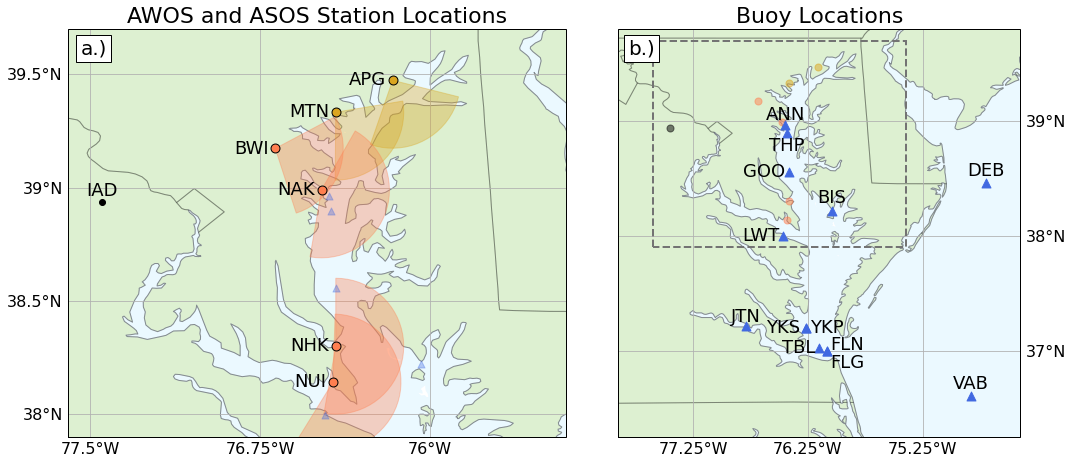

In [79]:
resolution = '10m'
fig, ax = plt.subplots(1, 2, figsize=(18, 7.5), subplot_kw={'projection': ccrs.PlateCarree()})


land = cfeature.NaturalEarthFeature('physical', 'land', resolution,
                                    edgecolor='face',
                                    facecolor="#ddf0d1")

water = cfeature.NaturalEarthFeature('physical', 'ocean', resolution,
                                    edgecolor='face',
                                    facecolor="#ebf9ff")

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution=resolution,
                                     category='cultural', name=shapename)

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': 'None', 'edgecolor': 'black', 'alpha':0.25}

for axi in range(len(ax)):
    ax[axi].add_feature(land)
    ax[axi].add_feature(water)
    ax[axi].add_geometries(shpreader.Reader(states_shp).geometries(),
                         ccrs.PlateCarree(),
                         styler=colorize_state)
    ax[axi].coastlines('10m',alpha=0.25)

center_lat = 38.7
center_lon = -76.4
map_1 = [center_lon-1.2, center_lon+1.0, center_lat-0.8, center_lat+1.0]
center_lat = 38.5
map_2 = [center_lon-1.5, center_lon+2.0, center_lat-2.25, center_lat+1.30]

ax[0].set_extent(map_1, ccrs.PlateCarree())
ax[1].set_extent(map_2, ccrs.PlateCarree())


gl = {0:ax[0].gridlines(draw_labels=True,
                        xlocs=np.arange(-78.25,-60,0.75),
                        ylocs=np.arange(37,41,0.5),
                       ),
      1:ax[1].gridlines(draw_labels=True,
                        xlocs=np.arange(-78.25,-60,1.0),
                        ylocs=np.arange(33,41,1.0),
                       )
     }
gl[0].ylabels_right = False
gl[1].ylabels_right = True
gl[1].ylabels_left = False

for axi in range(len(ax)):
    gl[axi].xlabel_style = {'size': 16, 'color': 'k'}
    gl[axi].xformatter = LONGITUDE_FORMATTER
    gl[axi].yformatter = LATITUDE_FORMATTER
    gl[axi].xlabels_top = False
    gl[axi].ylabel_style = {'size': 16, 'color': 'k'}
    
box_x = [map_1[0],map_1[0],map_1[1],map_1[1],map_1[0]]
box_y = [map_1[2],map_1[3],map_1[3],map_1[2],map_1[2]]  
ax[1].fill(box_x,box_y,zorder=2,facecolor='None',lw=2.0,edgecolor='#737373',ls='--')


# Station Labels:
for stn in station_dict:
    x, y = station_dict[stn]['lon'], station_dict[stn]['lat']
    ax[0].scatter(x,y,zorder=3,facecolor=station_dict[stn]['c'],marker='o',s=80,edgecolor='k')
    ax[0].text(x-0.03,y,stn,size=18,ha='right',va='center',zorder=3)
    pts  = np.arange(station_dict[stn]['min'],station_dict[stn]['max'],5.0)
    npts = pts.size
    fill_x = [x]
    fill_y = [y]
    for dd,wdir in enumerate(pts):
        d = 270.0 - wdir    # Convert met degrees to polar
        plt_dist = -0.30 # Met degrees are FROM dir... need negative distance!
        fill_x.append(x+plt_dist*np.cos(np.radians(d)))
        fill_y.append(y+plt_dist*np.sin(np.radians(d)))

    ax[0].fill(fill_x, fill_y,alpha=0.35,lw=None,color=station_dict[stn]['c'],zorder=2)
    x, y = station_dict[stn]['lon'], station_dict[stn]['lat']
    ax[1].scatter(x,y,zorder=3,facecolor=station_dict[stn]['c'],alpha=0.5,marker='o',s=50,lw=None,edgecolor=None)
    
x, y = float(awos_ds.sel(station='IAD').lon.data), float(awos_ds.sel(station='IAD').lat.data)
ax[0].scatter(x,y,zorder=3,c='k')
ax[0].text(x,y+0.01,'IAD',size=18,ha='center',va='bottom',zorder=3)


# Buoy Labels:
buoys_to_plot = list(buoy_ds.station.data)
bad_buoys = ['PMC','GRF','SRP','CAM','SLM','WDC'] # On land in WRF or Obs missing data

buoy_c = 'royalblue'
for bad_buoy in bad_buoys:
    buoys_to_plot.remove(bad_buoy)
for stn in buoys_to_plot:
    buoy_lon = float(buoy_ds.sel(station=stn).lon.data)
    buoy_lat = float(buoy_ds.sel(station=stn).lat.data)
    if stn == 'JTN':
        buoy_lat, buoy_lon = 37.21137, -76.78677
    x, y = buoy_lon, buoy_lat
    ax[1].scatter(x,y,zorder=3,c=buoy_c,marker='^',s=80)
    xa,ya = 0.0,0.0
    if stn == 'ANN':
        ha,va = 'center','bottom'
        xa,ya = 0.0,0.01
    elif stn == 'THP':
        ha,va = 'center','top'
        xa,ya = 0.0,-0.04
    elif stn == 'GOO':
        ha,va = 'right','center'
        xa,ya = -0.03,0.0
    elif stn == 'GRF':
        ha,va = 'left','center'
        xa,ya = 0.03,0.0
    elif stn == 'JTN':
        ha,va = 'center','bottom'
        xa,ya = 0.0,0.0
    elif stn == 'LWT':
        ha,va = 'right','center'
        xa,ya = -0.03,0.0
    elif stn == 'YKS':
        ha,va = 'right','center'
        xa,ya = -0.05,0.0
    elif stn == 'YKP':
        ha,va = 'left','center'
        xa,ya = 0.03,0.0
    elif stn == 'TBL':
        ha,va = 'right','center'
        xa,ya = -0.03,0.0
    elif stn == 'FLN':
        ha,va = 'left','bottom'
        xa,ya = 0.03,-0.03
    elif stn == 'FLG':
        ha,va = 'left','top'
        xa,ya = 0.03,-0.03
    else:
        ha,va = 'center','bottom'
        xa,ya = 0.0,0.03
    ax[1].text(x+xa,y+ya,stn,size=18,ha=ha,va=va,zorder=3)
    x, y = buoy_lon, buoy_lat
    ax[0].scatter(x,y,zorder=3,facecolor=buoy_c,alpha=0.35,marker='^',s=50,edgecolor=None)
x, y = float(awos_ds.sel(station='IAD').lon.data), float(awos_ds.sel(station='IAD').lat.data)
ax[1].scatter(x,y,zorder=3,facecolor='k',alpha=0.5,marker='o',s=50,lw=None,edgecolor=None)


ax[0].set_title('AWOS and ASOS Station Locations',size=22)
ax[1].set_title('Buoy Locations',size=22)

props = dict(facecolor='w', alpha=1.0)

# place a text box in upper left in axes coords
map1_width  = map_1[1] - map_1[0]
map1_height = map_1[3] - map_1[2]

map2_width  = map_2[1] - map_2[0]
map2_height = map_2[3] - map_2[2]

txt_loc1 = map_1[0]+0.025*map1_width, map_1[3]-0.025*map1_height
txt_loc2 = map_2[0]+0.025*map2_width, map_2[3]-0.025*map2_height
ax[0].text(txt_loc1[0],txt_loc1[1], 'a.)', bbox=props, ha='left',va='top',fontsize=20)
ax[1].text(txt_loc2[0],txt_loc2[1], 'b.)', bbox=props, ha='left',va='top',fontsize=20)
plt.subplots_adjust(wspace=0.001,hspace=0.001)
figname = '{}StationLocation'.format(save_dir)
if save_figs:
    plt.savefig('{}.png'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    plt.savefig('{}.pdf'.format(figname), bbox_inches = 'tight',pad_inches = 0.1)
    print(figname)
plt.show()

# Start Detection

# User settings:

In [17]:
fdir      = '/Users/hawbecke/Research/Chesapeake/Data/Obs/'

obs_type = 'ASOS'

detection_methods = ['StaufferThompson2015', 'Stauffer2015', 'Sikora2010']


# Start time:     0900 Local (1300 UTC) 
start_time = pd.to_timedelta(13,unit='h')
# End time:       1600 Local (2000 UTC)
end_time   = pd.to_timedelta(20,unit='h')

year_range = np.arange(2019,2020,1)
nyears = year_range.size

# Dates (month-day) to analyze:
date_start = '01-01'
date_end   = '12-31'

light_winds = 3.08667 # m/s
#light_winds = 2.57222 # m/s

sample_rate = '60min'

min_points = 3

show_plot = True

if obs_type == 'ASOS':
    ds_stn = asos_ds
elif obs_type == 'AWOS':
    ds_stn = awos_ds
near_shore_stations  = []
inland_station_names = []
for stn in ds_stn.get_index('station'):
    if ds_stn.sel(station=stn).region.data == 'inland':
        inland_station_names.append(stn)
    if ds_stn.sel(station=stn).region.data == 'coastal':
        near_shore_stations.append(stn)

if obs_type == 'ASOS':
    inland_station_names = ['IAD','DCA','MRB','HGR']
elif obs_type == 'AWOS':
    inland_station_names = ['IAD','CJR','GAI','FDK']


print(near_shore_stations)
print(inland_station_names)


['BWI', 'NAK', 'NHK', 'NUI']
['IAD', 'DCA', 'MRB', 'HGR']


# Plot the stations:

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:388: MatplotlibDeprecationWarning: 
The 'inframe' parameter of draw() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use Axes.redraw_in_frame() instead. If any parameter follows 'inframe', they should be passed as keyword, not positionally.
  inframe=inframe)


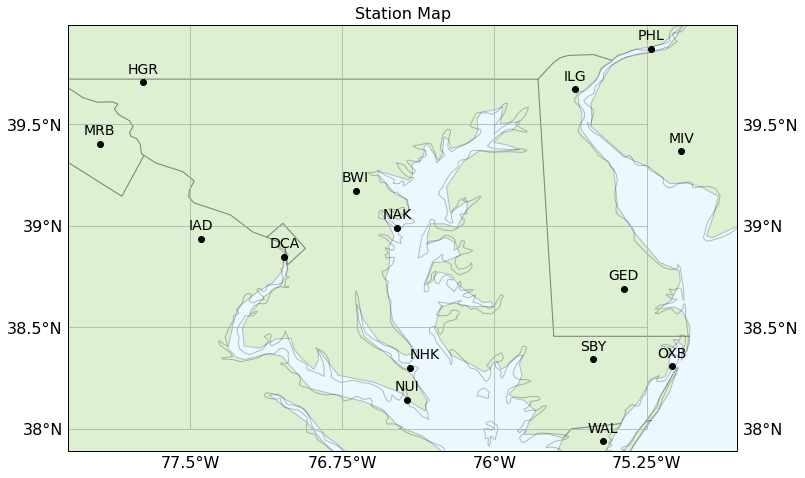

In [18]:
all_stations = sorted(np.unique(['ADW', 'APG', 'BWI', 'CBE', 'CGE', 'CGS', 'CJR', 'ESN', 'FDK',
       'GAI', 'HGR', 'IAD', 'MTN', 'NAK', 'NHK', 'NUI', 'OXB', 'SBY',
       'W29', 'BWI', 'DCA', 'GED', 'HGR', 'IAD', 'ILG', 'MIV', 'MRB', 'NAK',
       'NHK', 'NUI', 'OXB', 'PHL', 'SBY', 'WAL']))


fig, ax = plt.subplots(1, 1, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})


land = cfeature.NaturalEarthFeature('physical', 'land', resolution,
                                    edgecolor='face',
                                    facecolor="#ddf0d1")

water = cfeature.NaturalEarthFeature('physical', 'ocean', resolution,
                                    edgecolor='face',
                                    facecolor="#ebf9ff")

shapename = 'admin_1_states_provinces_lakes_shp'
states_shp = shpreader.natural_earth(resolution=resolution,
                                     category='cultural', name=shapename)

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': 'None', 'edgecolor': 'black', 'alpha':0.25}

ax.add_feature(land)
ax.add_feature(water)
ax.add_geometries(shpreader.Reader(states_shp).geometries(),
                     ccrs.PlateCarree(),
                     styler=colorize_state)
ax.coastlines('10m',alpha=0.25)

center_lat = 38.690760
center_lon = -76.401987
map_1 = [center_lon-1.7, center_lon+1.6, center_lat-0.8, center_lat+1.3]

ax.set_extent(map_1, ccrs.PlateCarree())

parallels = np.arange(38.0,40.1,0.5)
meridians = np.arange(-80.5,-74.9,0.75)

gl = ax.gridlines(draw_labels=True,
                     xlocs=meridians,
                     ylocs=parallels,
                    )
gl.xlabel_style = {'size': 16, 'color': 'k'}
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabel_style = {'size': 16, 'color': 'k'}


#m.drawparallels(parallels,labels=[True,False,True,False],color='#93994d',size=14)
#m.drawmeridians(meridians,labels=[True,False,False,True],color='#93994d',size=14)

# Station Labels:
for stn in ds_stn.station.values:
    x, y = ds_stn.sel(station=stn).lon, ds_stn.sel(station=stn).lat
    ax.scatter(x,y,zorder=3,c='k')
    if stn == '2W6':
        ax.text(x,y+0.03,stn,size=14,ha='right',va='bottom')
    elif stn == 'NHK':
        ax.text(x,y+0.03,stn,size=14,ha='left',va='bottom')
    else:
        ax.text(x,y+0.03,stn,size=14,ha='center',va='bottom')
    if ~np.isnan(ds_stn.sel(station=stn).onshore_min.values.astype(float)):
        if stn == 'NAK':
            pts = np.arange(50,170.1,5.0)
        elif stn == 'NHK':
            pts = np.arange(10,130.1,5.0)
        elif stn == 'NUI':
            pts = np.arange(20,140.1,5.0)
        elif stn == 'MTN':
            pts = np.arange(80,180.1,5.0)
        elif stn == 'APG':
            pts = np.arange(60,180.1,5.0)
        else:
            pts  = np.arange(ds_stn.sel(station=stn).onshore_min.data,ds_stn.sel(station=stn).onshore_max.data,5.0)
        npts = pts.size
        fill_x = [x]
        fill_y = [y]
        for dd,wdir in enumerate(pts):
            d = 270.0 - wdir    # Convert met degrees to polar
            plt_dist = -30000.0 # Met degrees are FROM dir... need negative distance!
            fill_x.append(x+plt_dist*np.cos(np.radians(d)))
            fill_y.append(y+plt_dist*np.sin(np.radians(d)))

        plt.fill(fill_x, fill_y,alpha=0.35,lw=None,color='#e3e022')

    ax.tick_params(size=14)
    ax.set_title('Station Map',size=16)


plt.show()

# Find and validate bay breezes:

In [58]:
bb_file_name = 'allDays_TrueSampleRate' # USE THIS ONE FOR FIRST PAPER!
#bb_file_name = 'allDays_TrueSampleRate_WRFMinMax' # USE THIS ONE FOR NUMERICAL DETECTION PAPER

bay_breeze_ds_f = {}

for inland_station_name in inland_station_names[:1]:
    for detection_method in detection_methods:
        if detection_method == 'StaufferThompson2015':
            sample_rate = '60min'
        elif detection_method == 'Stauffer2015':
            sample_rate = '5min'
        elif detection_method == 'Sikora2010':
            sample_rate = '60min'            
        
        new_f_name = '{}{}2019_to_2020_{}_bay_breeze_inland{}_{}.nc'.format(fdir,obs_type,detection_method,inland_station_name,bb_file_name)

        if path.exists(new_f_name):
            print('loading in full dataset!')
            bay_breeze_ds = xr.open_dataset(new_f_name)
        else:
            #month_count = np.zeros((nstations,period_len))
            near_shore_station_num = len(near_shore_stations)
            missing_days   = np.zeros((near_shore_station_num,nyears,12)) 
            analyzed_days  = np.zeros((near_shore_station_num,nyears,12)) 
            detected_days  = np.zeros((near_shore_station_num,nyears,12)) 
            validated_days = np.zeros((near_shore_station_num,nyears,12)) 

            for ss,stn in enumerate(near_shore_stations):   
                print('starting station: {}'.format(stn))
                ds               = ds_stn.sel(station=stn)
                if use_wrf_minmax:
                    ds['onshore_min'] = station_dict[stn]['min']
                    ds['onshore_max'] = station_dict[stn]['max']
                inland_stationsf = ds_stn.sel(station=inland_station_name)
                bay_breeze_days = []
                if ss == 0:
                    bay_breeze_detected    = []
                    bay_breeze_validated   = []
                    bay_breeze_passage     = []
                    bay_breeze_cldORprecip = []
                    bay_breeze_day_dict    = {}
                    days                   = []

                elif ss == 1:
                    bay_breeze_detected_f         = np.asarray([[None]*day_count]*near_shore_station_num)
                    bay_breeze_detected_f[0,:]    = bay_breeze_detected
                    bay_breeze_validated_f        = np.asarray([[None]*day_count]*near_shore_station_num)
                    bay_breeze_validated_f[0,:]   = bay_breeze_validated
                    bay_breeze_passage_f          = np.asarray([[None]*day_count]*near_shore_station_num)
                    bay_breeze_passage_f[0,:]     = bay_breeze_passage
                    bay_breeze_cldORprecip_f      = np.asarray([[None]*day_count]*near_shore_station_num)
                    bay_breeze_cldORprecip_f[0,:] = bay_breeze_passage

                day_count = 0

                for yy,year in enumerate(year_range):
                    print('Year: {}'.format(year))
                    period_start = pd.to_datetime('{0}-{1} 00:00:00'.format(year,date_start))
                    period_end   = pd.to_datetime('{0}-{1} 23:59:59'.format(year,date_end))
                    month_start  = period_start.month
                    period_len   = period_end.month - period_start.month
                    for day in pd.date_range(start=period_start, end=period_end):
                        station = ds.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                                    str(pd.to_datetime(day)+end_time)))
                        inland_stations = inland_stationsf.sel(datetime=slice(str(pd.to_datetime(day)+start_time),
                                                    str(pd.to_datetime(day)+end_time)))

                        bay_breeze = DetectBayBreeze(station,inland=inland_stations,verbose=False,resample=True,
                                                     sample_rate=sample_rate,show_plot=False,method=detection_method,
                                                     remove_cldORprecip=False,light_winds=light_winds)


                        month_ind = day.month - month_start            
                        if bay_breeze.analyzed:
                            analyzed_days[ss,yy,month_ind] += 1
                        else:
                            missing_days[ss,yy,month_ind] += 1
                        if bay_breeze.detected: detected_days[ss,yy,month_ind] += 1
                        if bay_breeze.validated: validated_days[ss,yy,month_ind] += 1

                        if ss == 0: 
                            bay_breeze_detected.append(bay_breeze.detected)
                            bay_breeze_validated.append(bay_breeze.validated)
                            bay_breeze_cldORprecip.append(bay_breeze.cldsORprecip)
                        else:
                            bay_breeze_detected_f[ss,day_count]    = bay_breeze.detected
                            bay_breeze_validated_f[ss,day_count]   = bay_breeze.validated
                            bay_breeze_cldORprecip_f[ss,day_count] = bay_breeze.cldsORprecip

                        if bay_breeze.detected:
                            if bay_breeze.validated:
                                fill_color = 'darkgreen'
                                bay_breeze_days.append(pd.to_datetime(bay_breeze.passage.values).strftime('%Y-%m-%d %H:%M:%S'))
                            else:
                                fill_color = 'darkred'
                            if ss == 0: 
                                bay_breeze_passage.append(pd.to_datetime(bay_breeze.passage.values).strftime('%Y-%m-%d %H:%M:%S'))
                            else:
                                bay_breeze_passage_f[ss,day_count] = pd.to_datetime(bay_breeze.passage.values).strftime('%Y-%m-%d %H:%M:%S')
                        else:
                            if ss == 0: 
                                bay_breeze_passage.append('None')
                            else:
                                bay_breeze_passage_f[ss,day_count] = 'None'

                        if ss == 0: days.append(day)
                        day_count += 1

                bay_breeze_day_dict[stn] = bay_breeze_days   
            


            bay_breeze_ds = xr.Dataset({
                              'analyzed_count': (['station','year','month'],analyzed_days),
                               'missing_count': (['station','year','month'],missing_days),
                              'detected_count': (['station','year','month'],detected_days),
                             'validated_count': (['station','year','month'],validated_days),
                               'detected_days': (['station','day'],bay_breeze_detected_f.astype('str')),
                              'validated_days': (['station','day'],bay_breeze_validated_f.astype('str')),
                            'cldORprecip_days': (['station','day'],bay_breeze_cldORprecip_f.astype('str')),
                                'passage_time': (['station','day'],bay_breeze_passage_f.astype('str'))
                                        },
                             coords={'station': (['station'],near_shore_stations),
                                        'year': (['year'],year_range),
                                       'month': (['month'],np.arange(month_start,month_start+period_len+1)),
                                         'day': (['day'],days)
                                     })
            bay_breeze_ds.attrs['inland_station'] = inland_station_name

            bay_breeze_ds.to_netcdf(new_f_name,'w')
        bay_breeze_ds_f[detection_method] = bay_breeze_ds

loading in full dataset!
loading in full dataset!
loading in full dataset!


In [59]:
bay_breeze_ds_f = {}
for obs_type in ['ASOS','AWOS']:
    bay_breeze_ds_f[obs_type] = {}
    if obs_type == 'ASOS':
        inland_station_names = ['IAD','DCA','MRB','HGR']
    elif obs_type == 'AWOS':
        inland_station_names = ['IAD','CJR','GAI','FDK']

    for detection_method in detection_methods:
        bay_breeze_ds_f[obs_type][detection_method] = {}
        for inland_station_name in inland_station_names[:1]:

            fname = '{}{}2019_to_2020_{}_bay_breeze_inland{}_{}.nc'.format(fdir,obs_type,detection_method,inland_station_name,bb_file_name)

            #fname = '{}{}2019_to_2020_{}_bay_breeze_inland{}_allDays.nc'.format(fdir,obs_type,detection_method,inland_station_name)
            #fname = '{}{}2019_to_2020_{}_bay_breeze_inland{}_rmCLD.nc'.format(fdir,obs_type,detection_method,inland_station_name)
            #fname = '{}{}2019_to_2020_{}_bay_breeze_inland{}_test.nc'.format(fdir,obs_type,detection_method,inland_station_name)
            bay_breeze_ds_f[obs_type][detection_method][inland_station_name] = xr.open_dataset(fname)
        


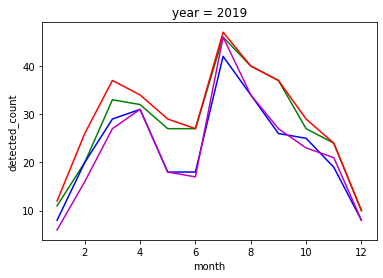

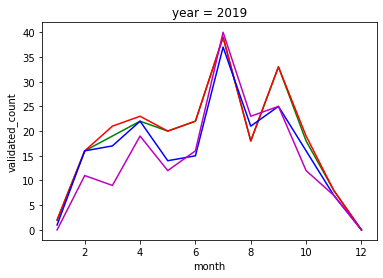

In [60]:
lessDays = xr.open_dataset('{}{}2019_to_2020_{}_bay_breeze_inland{}_rmCLD.nc'.format(
                            fdir,'AWOS','StaufferThompson2015',inland_station_name))

moreDays = xr.open_dataset('{}{}2019_to_2020_{}_bay_breeze_inland{}_allDays.nc'.format(
                            fdir,'AWOS','StaufferThompson2015',inland_station_name))

lowerLightWind = xr.open_dataset('{}{}2019_to_2020_{}_bay_breeze_inland{}_allDays_TrueSampleRate.nc'.format(
                            fdir,'AWOS','StaufferThompson2015',inland_station_name))

wrf_minmax = xr.open_dataset('{}{}2019_to_2020_{}_bay_breeze_inland{}_allDays_TrueSampleRate_WRFMinMax.nc'.format(
                            fdir,'AWOS','StaufferThompson2015',inland_station_name))

lessDays.detected_count.sum(dim='station').plot(c='g')
moreDays.detected_count.sum(dim='station').plot(c='r')
lowerLightWind.detected_count.sum(dim='station').plot(c='b')
wrf_minmax.detected_count.sum(dim='station').plot(c='m')
plt.show()

lessDays.validated_count.sum(dim='station').plot(c='g')
moreDays.validated_count.sum(dim='station').plot(c='r')
lowerLightWind.validated_count.sum(dim='station').plot(c='b')
wrf_minmax.validated_count.sum(dim='station').plot(c='m')
plt.show()

# Check Sensitivity to Reference Inland Station:

In [61]:
days = bay_breeze_ds_f['ASOS']['StaufferThompson2015']['IAD'].day.data
inland_station_name = 'IAD'

bb_passage_dict = {}

for detection_method in detection_methods:
    bb_passage = []
    for obs_type in ['ASOS','AWOS']:
        for dd, day in enumerate(days):
            day_line = '{}: '.format(str(day)[:10])
            if dd == 0:
                month_0 = int(str(day)[5:7])
            month = int(str(day)[5:7])
            if month != month_0:
                month_0 = month
            
            bb_ds = bay_breeze_ds_f[obs_type][detection_method][inland_station_name].sel(day=day)
            for ss,stn in enumerate(bb_ds.station.data):
                val_bool = bb_ds.sel(station=stn).validated_days.data
                if val_bool == 'True':
                    bb_passage = np.append(bb_passage,'{} [{}]'.format(bb_ds.sel(station=stn).passage_time.data,stn))
    bb_passage = np.unique(bb_passage)
    bb_passage_dict[detection_method] = bb_passage


In [62]:
days = bay_breeze_ds_f['ASOS']['StaufferThompson2015']['IAD'].day.data
inland_station_name = 'IAD'

bb_passage_f = []

for obs_type in ['ASOS','AWOS']:
    for detection_method in detection_methods:
        for dd, day in enumerate(days):
            day_line = '{}: '.format(str(day)[:10])
            if dd == 0:
                month_0 = int(str(day)[5:7])
            month = int(str(day)[5:7])
            if month != month_0:
                month_0 = month
            
            bb_ds = bay_breeze_ds_f[obs_type][detection_method][inland_station_name].sel(day=day)
            for ss,stn in enumerate(bb_ds.station.data):
                val_bool = bb_ds.sel(station=stn).validated_days.data
                if val_bool == 'True':
                    bb_passage = np.append(bb_passage,'{} [{}]'.format(bb_ds.sel(station=stn).passage_time.data,stn))
bb_passage_f = np.unique(bb_passage)


In [63]:
days = bay_breeze_ds_f['ASOS']['StaufferThompson2015']['IAD'].day.data

num_per_inland_station = {}

for obs_type in ['ASOS','AWOS']:
    #print(obs_type)
    num_per_inland_station[obs_type] = {}
    for detection_method in detection_methods:
        #print(detection_method)
        num_per_inland_station[obs_type][detection_method] = {}
        for dd, day in enumerate(days):
            day_line = '{}: '.format(str(day)[:10])
            if dd == 0:
                month_0 = int(str(day)[5:7])
            month = int(str(day)[5:7])
            if month != month_0:
                #print()
                month_0 = month
            for inland_station_name in list(bay_breeze_ds_f[obs_type][detection_method].keys()):
                if dd == 0: num_per_inland_station[obs_type][detection_method][inland_station_name] = 0
                got_one_today = False
                inland_str = ''
                bb_ds = bay_breeze_ds_f[obs_type][detection_method][inland_station_name].sel(day=day)
                for ss,stn in enumerate(bb_ds.station.data):
                    val_bool = bb_ds.sel(station=stn).validated_days.data
                    if val_bool == 'True':
                        if got_one_today == True:
                            inland_str += ',{}'.format(stn)
                        else:
                            inland_str = '\t\t{}:{}'.format(inland_station_name,stn)
                            got_one_today = True
                        num_per_inland_station[obs_type][detection_method][inland_station_name] += 1
                if inland_str != '': 
                    day_line += inland_str
        #    if day_line != '{}: '.format(str(day)[:10]): print(day_line)
        #print('\n\n\n\n')
                
            


In [64]:
for obs_type in ['ASOS','AWOS']:
    for detection_method in detection_methods:
        for inland_station_name in list(bay_breeze_ds_f[obs_type][detection_method].keys()):
            print(obs_type,detection_method,inland_station_name,num_per_inland_station[obs_type][detection_method][inland_station_name])

ASOS StaufferThompson2015 IAD 131
ASOS Stauffer2015 IAD 87
ASOS Sikora2010 IAD 27
AWOS StaufferThompson2015 IAD 191
AWOS Stauffer2015 IAD 84
AWOS Sikora2010 IAD 28


In [386]:
for obs_type in ['ASOS','AWOS']:
    for detection_method in detection_methods:
        for inland_station_name in list(bay_breeze_ds_f[obs_type][detection_method].keys()):
            print(obs_type,detection_method,inland_station_name,num_per_inland_station[obs_type][detection_method][inland_station_name])

ASOS StaufferThompson2015 IAD 70
ASOS Stauffer2015 IAD 99
ASOS Sikora2010 IAD 32
AWOS StaufferThompson2015 IAD 221
AWOS Stauffer2015 IAD 74
AWOS Sikora2010 IAD 56


In [377]:
for obs_type in ['ASOS','AWOS']:
    for detection_method in detection_methods:
        for inland_station_name in list(bay_breeze_ds_f[obs_type][detection_method].keys()):
            print(obs_type,detection_method,inland_station_name,num_per_inland_station[obs_type][detection_method][inland_station_name])

ASOS StaufferThompson2015 IAD 147
ASOS Stauffer2015 IAD 170
ASOS Sikora2010 IAD 64
AWOS StaufferThompson2015 IAD 244
AWOS Stauffer2015 IAD 81
AWOS Sikora2010 IAD 52


In [65]:
inland_station_name = 'IAD'
month_dict = {}

header_lines = r'\begin{table}\label{LABEL_PLACEHOLDER}' + '\n' + \
               r'\bgroup' + '\n' + r'\def\arraystretch{1.5}' + '\n' + \
               r'\begin{tabular}{|>{\centering\arraybackslash}m{0.07\textwidth}|' + \
               r'>{\centering\arraybackslash}m{0.25\textwidth}|'*3  + '}' + \
               '\n' + r'\hline'
footer_lines = r'\end{tabular}' + '\n' + r'\egroup' + '\n' + r'\end{table}'

detection_method_names_dict = {'StaufferThompson2015':'Stauffer and Thompson (2015)',
                                       'Stauffer2015':'Stauffer et al. (2015)',
                                         'Sikora2010':'Sikora et al. (2010)'}
month_lines_dict = {}
for obs_type in ['ASOS','AWOS']:
    if obs_type == 'ASOS': inland_station_name = 'IAD'
    if obs_type == 'AWOS': inland_station_name = 'IAD'
        
    #print(header_lines)
    #print(obs_type)
    methods_line = 'Month & '
    month_lines_dict[obs_type] = ['']*12
    month_dict[obs_type] = {}
    for detection_method in detection_methods:
        methods_line += detection_method_names_dict[detection_method] +' & '
        #print(detection_method)
        month_dict[obs_type][detection_method] = {}
        
        for dd, day in enumerate(days):
            day_line = '{}: '.format(str(day)[:10])
            if dd == 0:
                month_0 = int(str(day)[5:7])
                month_dict[obs_type][detection_method][month_0] = ''
            month = int(str(day)[5:7])
            if month != month_0:
                month_dict[obs_type][detection_method][month_0] = month_dict[obs_type][detection_method][month_0][:-2]
                #print(month_0,month_dict[obs_type][detection_method][month_0])
                if month_dict[obs_type][detection_method][month_0] == '':
                    month_dict[obs_type][detection_method][month_0] = '--'
                month_lines_dict[obs_type][month_0-1] += month_dict[obs_type][detection_method][month_0] + ' & '
                month_0 = month
                month_dict[obs_type][detection_method][month_0] = ''
            got_one_today = False
            day_stn_list = []
            bb_ds = bay_breeze_ds_f[obs_type][detection_method][inland_station_name].sel(day=day)
            for ss,stn in enumerate(bb_ds.station.data):
                val_bool = bb_ds.sel(station=stn).validated_days.data
                if val_bool == 'True':
                    if got_one_today == True:
                        day_stn_list.append(stn)
                    else:
                        month_dict[obs_type][detection_method][month_0] += str(int(str(day)[8:10]))
                        day_stn_list = [stn]
                        got_one_today = True
            if len(day_stn_list) > 1:
                day_str = '({}), '.format(len(day_stn_list))
            else:
                day_str = ', '
            
            if got_one_today:
                month_dict[obs_type][detection_method][month_0] += day_str
        month_dict[obs_type][detection_method][month_0] = month_dict[obs_type][detection_method][month_0][:-2]
        #print(month_0,month_dict[obs_type][detection_method][month_0])
        if month_dict[obs_type][detection_method][month_0] == '':
            month_dict[obs_type][detection_method][month_0] = '--'
        month_lines_dict[obs_type][month_0-1] += month_dict[obs_type][detection_method][month_0] + ' & '
        
    methods_line = methods_line[:-2]
    methods_line += r'\\'
    print(header_lines.replace('LABEL_PLACEHOLDER','table:{}'.format(obs_type)))
    print(methods_line)
    print(r'\hline')
    for mm, month in enumerate(month_lines_dict[obs_type]):
        month_line = str(mm+1) + ' & ' + month[:-2] + r'\\'
        print(month_line)
        print(r'\hline')

    print(footer_lines)
    print('\n\n\n\n')
    


\begin{table}\label{table:ASOS}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|>{\centering\arraybackslash}m{0.07\textwidth}|>{\centering\arraybackslash}m{0.25\textwidth}|>{\centering\arraybackslash}m{0.25\textwidth}|>{\centering\arraybackslash}m{0.25\textwidth}|}
\hline
Month & Stauffer and Thompson (2015) & Stauffer et al. (2015) & Sikora et al. (2010) \\
\hline
1 & 8, 17 & 8, 17(2) & -- \\
\hline
2 & 10(2), 11, 14(2), 16, 20, 23, 28(2) & 1, 10, 14, 16, 21, 28 & -- \\
\hline
3 & 5, 8, 10, 13, 17, 19, 20, 21(2), 24(2), 29(2), 30(2) & 5, 15, 19, 21, 24, 29(2) & 19, 20, 29 \\
\hline
4 & 1, 4, 5, 6(2), 7(3), 10, 13, 14, 18, 19, 20, 21(2), 23, 26, 30(2) & 4, 5, 7, 12, 17, 20, 21, 23, 26, 30 & 1, 6, 10, 14, 20, 26, 30 \\
\hline
5 & 2, 6, 9, 11, 12, 18, 19, 23, 27, 28, 30 & 2, 4, 5, 6, 18(2), 23, 25, 30 & -- \\
\hline
6 & 1, 17, 19, 24, 26, 27, 28(2) & 1, 7, 12(3), 17, 19, 24, 26, 27, 28 & 24, 26, 28 \\
\hline
7 & 1, 5, 7, 15, 16(2), 17, 19, 24(2), 25, 27, 28(2), 29(2), 30 & 1, 5, 15, 16, 

# Merged tables:

In [66]:
def remove_duplicates(days,asos_days,awos_days,format_text=False,good_days=None):
    for dd,day in enumerate(days):
        day = day.strip()
        #print(day)
        if '(' in day:
            day = day.split('(')[0]
        if day != '--':
            days[dd] = int(day)
        else:
            days[dd] = 0
    days = list(np.unique(days))
    if 0 in days:
        days.remove(0)
    
    days_temp = days.copy()
    if good_days != None:
        for dd,day in enumerate(days_temp):
            if day not in good_days:
                days.remove(day)
    if format_text:
        formatted_days = days.copy()
        for dd,day in enumerate(days):
            day = str(day)
            if (day in asos_days) & (day not in awos_days):
                #print('asos',day)
                days[dd] = r'\textbf{\textcolor{ASOS}{' + day + '}}'

            elif (day in awos_days) & (day not in asos_days):
                days[dd] = r'\textbf{\textcolor{AWOS}{' + day + '}}'
            else:
                days[dd] = day

        days = ', '.join(np.asarray(days,dtype=str))
        if days == '':
            days = ' -- '
    return(days)



In [67]:
asos_month_lines = month_lines_dict['ASOS']
awos_month_lines = month_lines_dict['AWOS']

print(header_lines.replace('LABEL_PLACEHOLDER','table:{}'.format('combined')))
print(methods_line)
print(r'\hline')
for mm,month in enumerate(range(1,13)):
    asos_days = asos_month_lines[mm].split('&')
    awos_days = awos_month_lines[mm].split('&')

    StTh_days = list(np.append(asos_days[0].split(','),awos_days[0].split(',')))
    St_days   = list(np.append(asos_days[1].split(','),awos_days[1].split(',')))
    Sk_days   = list(np.append(asos_days[2].split(','),awos_days[2].split(',')))
    
    
    StTh_days = remove_duplicates(StTh_days,asos_days[0],awos_days[0],format_text=True)
    St_days = remove_duplicates(St_days,asos_days[1],awos_days[1],format_text=True)
    Sk_days = remove_duplicates(Sk_days,asos_days[2],awos_days[2],format_text=True)
    #if month == 10: 
    #    print(asos_days[0])
    #    print(awos_days[0])
    print(str(month) + ' & ' + StTh_days + ' & ' + St_days + ' & ' + Sk_days + r' \\')
    print(r'\hline')

print(footer_lines)
print('\n\n\n\n')    
    

    

\begin{table}\label{table:combined}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|>{\centering\arraybackslash}m{0.07\textwidth}|>{\centering\arraybackslash}m{0.25\textwidth}|>{\centering\arraybackslash}m{0.25\textwidth}|>{\centering\arraybackslash}m{0.25\textwidth}|}
\hline
Month & Stauffer and Thompson (2015) & Stauffer et al. (2015) & Sikora et al. (2010) \\
\hline
1 & 8, \textbf{\textcolor{ASOS}{17}}, \textbf{\textcolor{AWOS}{28}} & \textbf{\textcolor{ASOS}{8}}, \textbf{\textcolor{ASOS}{17}} &  --  \\
\hline
2 & 2, 4, \textbf{\textcolor{AWOS}{5}}, 10, 11, \textbf{\textcolor{AWOS}{12}}, 14, \textbf{\textcolor{AWOS}{15}}, 16, \textbf{\textcolor{AWOS}{19}}, \textbf{\textcolor{ASOS}{20}}, \textbf{\textcolor{AWOS}{22}}, \textbf{\textcolor{ASOS}{23}}, \textbf{\textcolor{AWOS}{24}}, \textbf{\textcolor{AWOS}{26}}, \textbf{\textcolor{ASOS}{28}} & 1, 2, 10, 14, 16, \textbf{\textcolor{ASOS}{21}}, \textbf{\textcolor{AWOS}{23}}, \textbf{\textcolor{AWOS}{26}}, \textbf{\textcolor{ASOS}{28}} & \t

# Days to check radar/obs:

In [68]:
asos_month_lines = month_lines_dict['ASOS']
awos_month_lines = month_lines_dict['AWOS']
full_month_dict = {}
count = 0
for mm,month in enumerate(range(1,13)):
    asos_days = asos_month_lines[mm].split('&')
    awos_days = awos_month_lines[mm].split('&')

    StTh_days = list(np.append(asos_days[0].split(','),awos_days[0].split(',')))
    St_days   = list(np.append(asos_days[1].split(','),awos_days[1].split(',')))
    Sk_days   = list(np.append(asos_days[2].split(','),awos_days[2].split(',')))
    
    
    StTh_days = remove_duplicates(StTh_days,asos_days[0],awos_days[0])
    St_days = remove_duplicates(St_days,asos_days[1],awos_days[1])
    Sk_days = remove_duplicates(Sk_days,asos_days[2],awos_days[2])
    full_day_list = list(np.unique(np.asarray(np.concatenate([StTh_days,St_days,Sk_days]),dtype=int)))
    for dd,day in enumerate(full_day_list):
        full_day_list[dd] = '2019-{0:02d}-{1:02d}'.format(month,day)
        
    full_month_dict[month] = full_day_list
    for day in full_day_list:
        for day_time in bb_passage_f:
            date = day_time[:10]
            if day == date:
                print("'{}': ' ',".format(day_time))
        count += 1
    print()
    

    

'2019-01-08 17:05:00 [NAK]': ' ',
'2019-01-08 18:00:00 [NAK]': ' ',
'2019-01-17 13:15:00 [NUI]': ' ',
'2019-01-17 14:05:00 [NHK]': ' ',
'2019-01-17 15:00:00 [NHK]': ' ',
'2019-01-28 16:00:00 [NAK]': ' ',

'2019-02-01 16:50:00 [NHK]': ' ',
'2019-02-02 16:15:00 [NHK]': ' ',
'2019-02-02 17:00:00 [NHK]': ' ',
'2019-02-04 16:00:00 [MTN]': ' ',
'2019-02-05 16:00:00 [NAK]': ' ',
'2019-02-10 15:20:00 [NAK]': ' ',
'2019-02-10 15:45:00 [NAK]': ' ',
'2019-02-10 15:55:00 [NHK]': ' ',
'2019-02-10 16:00:00 [NAK]': ' ',
'2019-02-10 16:00:00 [NHK]': ' ',
'2019-02-10 18:00:00 [NHK]': ' ',
'2019-02-11 15:00:00 [APG]': ' ',
'2019-02-11 18:00:00 [BWI]': ' ',
'2019-02-12 14:00:00 [APG]': ' ',
'2019-02-14 15:40:00 [NAK]': ' ',
'2019-02-14 15:55:00 [NHK]': ' ',
'2019-02-14 16:00:00 [NAK]': ' ',
'2019-02-14 16:00:00 [NHK]': ' ',
'2019-02-14 17:40:00 [NAK]': ' ',
'2019-02-14 18:00:00 [NAK]': ' ',
'2019-02-15 17:00:00 [MTN]': ' ',
'2019-02-16 15:25:00 [NHK]': ' ',
'2019-02-16 16:00:00 [NHK]': ' ',
'2019-02-16 1

In [69]:
count

180

In [38]:
command_str = 'curl -O '
gif_loc = 'https://www.wpc.ncep.noaa.gov/archives/sfc/{0:04d}/namussfc{0:04d}{1:02d}{2:02d}{3:02d}.gif'

for mm,month in enumerate(full_month_dict):
    for day in full_month_dict[month]:
        day = pd.to_datetime(day)
        f_loc = gif_loc.format(day.year,day.month,day.day,18)
        print(command_str + f_loc)

curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019010818.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019011718.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019012818.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019020218.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019020418.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019020518.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019021018.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019021118.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019021218.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019021418.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019021518.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2019/namussfc2019021618.gif
curl -O https://www.wpc.ncep.noaa.gov/archives/sfc/2

In [39]:
from analysis_days import analysis_days_dict

In [70]:
day_analysis_dict = analysis_days_dict[bb_file_name]

In [71]:
count = 0
good_days = []
for day in day_analysis_dict:
    day_analysis = day_analysis_dict[day].strip()
    if (day_analysis == 'radar clear. no synoptic.') or (day_analysis == 'radar clear. SWT in area.'):
    #if (day_analysis == 'radar clear. no synoptic.'):
        count+=1
        good_days = np.append(good_days,day[:10])

In [72]:
len(good_days)

335

In [73]:
asos_month_lines = month_lines_dict['ASOS']
awos_month_lines = month_lines_dict['AWOS']

print(header_lines.replace('LABEL_PLACEHOLDER','table:{}'.format('combined')))
print(methods_line)
print(r'\hline')
for mm,month in enumerate(range(1,13)):
    asos_days = asos_month_lines[mm].split('&')
    awos_days = awos_month_lines[mm].split('&')

    StTh_days = list(np.append(asos_days[0].split(','),awos_days[0].split(',')))
    St_days   = list(np.append(asos_days[1].split(','),awos_days[1].split(',')))
    Sk_days   = list(np.append(asos_days[2].split(','),awos_days[2].split(',')))
    good_days_month = []
    for day in good_days:
        if day[5:7] == '{0:02d}'.format(month):
            good_days_month.append(int(day[8:10]))
    good_days_month = list(np.unique(good_days_month))
#    print(good_days_month)
    StTh_days = remove_duplicates(StTh_days,asos_days[0],awos_days[0],format_text=True,good_days=good_days_month)
    St_days   = remove_duplicates(St_days,  asos_days[1],awos_days[1],format_text=True,good_days=good_days_month)
    #Sk_days   = remove_duplicates(Sk_days,  asos_days[2],awos_days[2],format_text=True,good_days=good_days_month)
    Sk_days   = remove_duplicates(Sk_days,  asos_days[2],awos_days[2],format_text=True,good_days=None)
    #if month == 10: 
    #    print(asos_days[0])
    #    print(awos_days[0])
    print(str(month) + ' & ' + StTh_days + ' & ' + St_days + ' & ' + Sk_days + r' \\')
    print(r'\hline')

print(footer_lines)
print('\n\n\n\n')    
    

    

\begin{table}\label{table:combined}
\bgroup
\def\arraystretch{1.5}
\begin{tabular}{|>{\centering\arraybackslash}m{0.07\textwidth}|>{\centering\arraybackslash}m{0.25\textwidth}|>{\centering\arraybackslash}m{0.25\textwidth}|>{\centering\arraybackslash}m{0.25\textwidth}|}
\hline
Month & Stauffer and Thompson (2015) & Stauffer et al. (2015) & Sikora et al. (2010) \\
\hline
1 & \textbf{\textcolor{AWOS}{28}} &  --  &  --  \\
\hline
2 & 2, 4, \textbf{\textcolor{AWOS}{5}}, 10, 14, \textbf{\textcolor{AWOS}{15}}, \textbf{\textcolor{AWOS}{19}}, \textbf{\textcolor{AWOS}{22}}, \textbf{\textcolor{AWOS}{26}}, \textbf{\textcolor{ASOS}{28}} & 2, 10, 14, \textbf{\textcolor{ASOS}{21}}, \textbf{\textcolor{AWOS}{26}}, \textbf{\textcolor{ASOS}{28}} & \textbf{\textcolor{AWOS}{2}}, \textbf{\textcolor{AWOS}{5}}, \textbf{\textcolor{AWOS}{10}}, \textbf{\textcolor{AWOS}{16}}, \textbf{\textcolor{AWOS}{22}}, \textbf{\textcolor{AWOS}{26}} \\
\hline
3 & 1, 5, 13, \textbf{\textcolor{ASOS}{17}}, 19, \textbf{\textcolor{

# July BB Days

### REMOVED CLOUDY / RAINY DAYS AUTOMATICALLY:

In [74]:
month = 7
mm = month-1

asos_days = asos_month_lines[mm].split('&')
awos_days = awos_month_lines[mm].split('&')

StTh_days = list(np.append(asos_days[0].split(','),awos_days[0].split(',')))
St_days   = list(np.append(asos_days[1].split(','),awos_days[1].split(',')))
Sk_days   = list(np.append(asos_days[2].split(','),awos_days[2].split(',')))

good_days_month = []
for day in good_days:
    if day[5:7] == '{0:02d}'.format(month):
        good_days_month.append(int(day[8:10]))
good_days_month = list(np.unique(good_days_month))

StTh_days = remove_duplicates(StTh_days,asos_days[0],awos_days[0],format_text=False,good_days=good_days_month)
St_days   = remove_duplicates(St_days,  asos_days[1],awos_days[1],format_text=False,good_days=good_days_month)
Sk_days   = remove_duplicates(Sk_days,  asos_days[2],awos_days[2],format_text=False,good_days=None)
july_days_dict = {'StaufferThompson2015':StTh_days,
                  'Stauffer2015':St_days,
                  'Sikora2010':Sk_days                  
                 }
print("bb_observed_dates = {")
for detection_method in july_days_dict.keys():
    print("                     {}".format("'{}'".format(detection_method)).rjust(22) + " : {")
    days = july_days_dict[detection_method]
    for day in days:
        day_str = '2019-{0:02d}-{1:02d}'.format(month,day)
        day_stn = []
        for bb_day in bb_passage_dict[detection_method]:
            if day_str in bb_day:
                day_stn.append(bb_day.split(' ')[-1].replace('[','').replace(']',''))
        print("                                               '{}' : {},".format(day_str,day_stn))
        #print(day_str)
    print('                                              },')
print("                     }")

bb_observed_dates = {
                     'StaufferThompson2015' : {
                                               '2019-07-01' : ['NAK'],
                                               '2019-07-02' : ['MTN', 'APG'],
                                               '2019-07-04' : ['NHK', 'NUI'],
                                               '2019-07-06' : ['MTN', 'APG'],
                                               '2019-07-09' : ['NAK', 'MTN'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-15' : ['NAK'],
                                               '2019-07-16' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-17' : ['MTN', 'NAK'],
                                               '2019-07-19' : ['NAK', 'MTN', 'NHK', 'APG'],
                                               '2019-07-22' : ['MTN'],
                                               '2019-07-24' : ['NUI', 'N

### NO REMOVED DAYS:

In [52]:
month = 7
mm = month-1

asos_days = asos_month_lines[mm].split('&')
awos_days = awos_month_lines[mm].split('&')

StTh_days = list(np.append(asos_days[0].split(','),awos_days[0].split(',')))
St_days   = list(np.append(asos_days[1].split(','),awos_days[1].split(',')))
Sk_days   = list(np.append(asos_days[2].split(','),awos_days[2].split(',')))

good_days_month = []
for day in good_days:
    if day[5:7] == '{0:02d}'.format(month):
        good_days_month.append(int(day[8:10]))
good_days_month = list(np.unique(good_days_month))

StTh_days = remove_duplicates(StTh_days,asos_days[0],awos_days[0],format_text=False,good_days=good_days_month)
St_days   = remove_duplicates(St_days,  asos_days[1],awos_days[1],format_text=False,good_days=good_days_month)
Sk_days   = remove_duplicates(Sk_days,  asos_days[2],awos_days[2],format_text=False,good_days=good_days_month)
july_days_dict = {'StaufferThompson2015':StTh_days,
                  'Stauffer2015':St_days,
                  'Sikora2010':Sk_days                  
                 }
print("bb_observed_dates = {")
for detection_method in july_days_dict.keys():
    print("                     {}".format("'{}'".format(detection_method)).rjust(22) + " : {")
    days = july_days_dict[detection_method]
    for day in days:
        day_str = '2019-{0:02d}-{1:02d}'.format(month,day)
        day_stn = []
        for bb_day in bb_passage:
            if day_str in bb_day:
                day_stn.append(bb_day.split(' ')[-1].replace('[','').replace(']',''))
        print("                                               '{}' : {},".format(day_str,day_stn))
        #print(day_str)
    print('                                              },')
print("                     }")

bb_observed_dates = {
                     'StaufferThompson2015' : {
                                               '2019-07-01' : ['NAK', 'NAK', 'NAK', 'NAK'],
                                               '2019-07-02' : ['APG', 'MTN'],
                                               '2019-07-04' : ['NHK', 'NUI', 'NHK'],
                                               '2019-07-06' : ['NUI', 'NUI', 'NUI', 'NUI', 'APG', 'MTN', 'NUI'],
                                               '2019-07-09' : ['MTN', 'NAK'],
                                               '2019-07-10' : ['NHK', 'NUI', 'NHK'],
                                               '2019-07-15' : ['NAK', 'NAK', 'NAK'],
                                               '2019-07-16' : ['NAK', 'NHK', 'NAK', 'NHK', 'NAK', 'NHK', 'NAK', 'NHK', 'MTN', 'NHK'],
                                               '2019-07-17' : ['NAK', 'NUI', 'NAK', 'MTN', 'NAK', 'NUI'],
                                               '2019-07-19' : ['NAK', 'NHK